In [71]:
# importing required packages

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [72]:
# reading the data 

sales_data = pd.read_excel('Pizza_Sale.xlsx')

ing_data = pd.read_excel('Pizza_ingredients.xlsx')

In [73]:
sales_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


## Data Cleaning

In [75]:
sales_data.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [76]:
sales_data.ffill(inplace=True)

In [77]:
# date time combine 

sales_data['order_datetime'] = sales_data['order_date'].astype(str) + ' ' + sales_data['order_time'].astype(str)

sales_data['order_datetime'] = pd.to_datetime(sales_data['order_datetime'])

C:\Users\Ajay\AppData\Local\Temp\ipykernel_14768\2230657510.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sales_data['order_datetime'] = pd.to_datetime(sales_data['order_datetime'])


In [78]:
sales_data['order_datetime'].head()

0   2015-01-01 11:38:36
1   2015-01-01 11:57:40
2   2015-01-01 11:57:40
3   2015-01-01 11:57:40
4   2015-01-01 11:57:40
Name: order_datetime, dtype: datetime64[ns]

In [79]:
sales_data['order_datetime'].tail()

48615   2015-12-31 21:23:10
48616   2015-12-31 21:23:10
48617   2015-12-31 21:23:10
48618   2015-12-31 22:09:54
48619   2015-12-31 23:02:05
Name: order_datetime, dtype: datetime64[ns]

In [80]:
sales_data = sales_data[['order_datetime', 'pizza_name', 'quantity']]

In [81]:
sales_data

,order_datetime,pizza_name,quantity
0,2015-01-01 11:38:36,The Hawaiian Pizza,1
1,2015-01-01 11:57:40,The Classic Deluxe Pizza,1
2,2015-01-01 11:57:40,The Five Cheese Pizza,1
3,2015-01-01 11:57:40,The Italian Supreme Pizza,1
4,2015-01-01 11:57:40,The Mexicana Pizza,1
...,...,...,...
48615,2015-12-31 21:23:10,The Chicken Alfredo Pizza,1
48616,2015-12-31 21:23:10,The Four Cheese Pizza,1
48617,2015-12-31 21:23:10,The Napolitana Pizza,1
48618,2015-12-31 22:09:54,The Mexicana Pizza,1


## Feature Engineering

In [83]:
# creating features 

sales_data['order_hour'] = sales_data['order_datetime'].dt.hour
sales_data['order_month'] = sales_data['order_datetime'].dt.month
sales_data['order_day'] = sales_data['order_datetime'] .dt.strftime("%d")
sales_data['order_date'] = sales_data['order_datetime'].dt.date

In [84]:
temp = sales_data[['order_datetime', 'order_month', 'order_date', 'order_hour', 'pizza_name', 'quantity']]
temp = temp[temp['pizza_name'] == 'The Barbecue Chicken Pizza']
temp = temp.groupby(['order_month', 'order_date'], as_index=False)['quantity'].sum()

In [85]:
temp

,order_month,order_date,quantity
0,1,2015-01-01,11
1,1,2015-01-02,12
2,1,2015-01-03,2
3,1,2015-01-04,2
4,1,2015-01-05,6
...,...,...,...
353,12,2015-12-27,4
354,12,2015-12-28,2
355,12,2015-12-29,4
356,12,2015-12-30,6


In [86]:
temp.set_index('order_date', inplace=True)

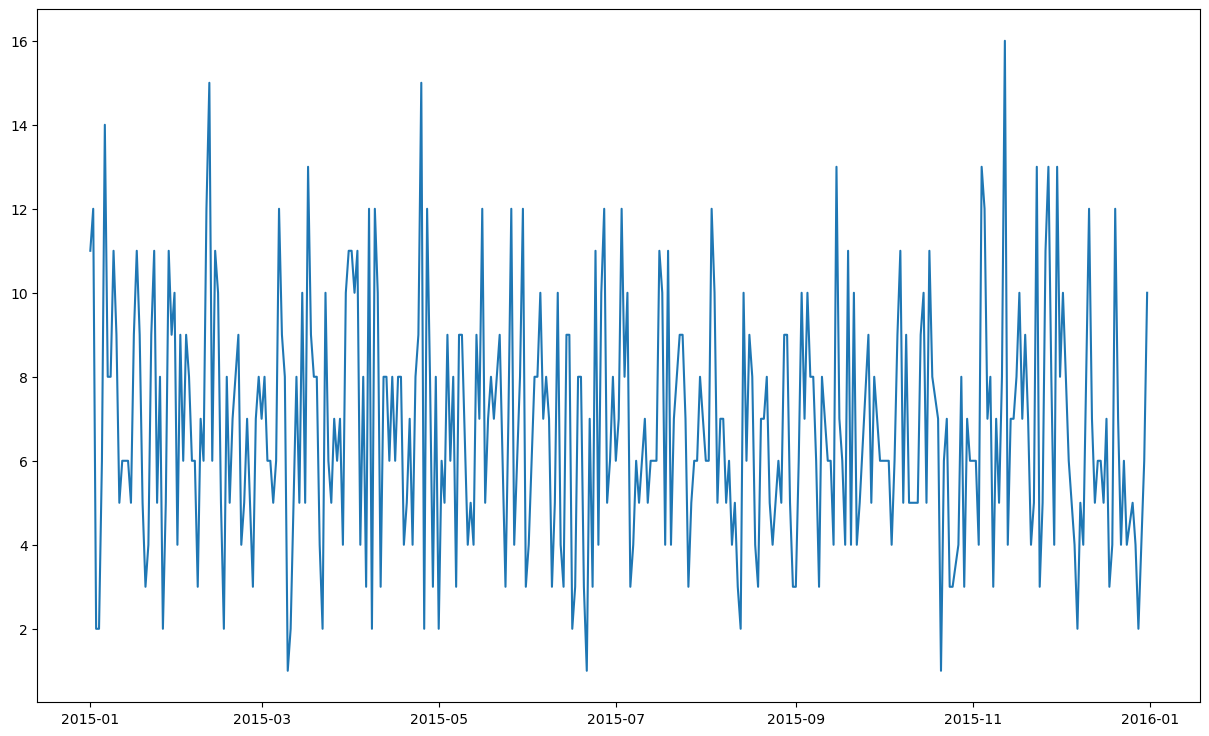

In [87]:
plt.figure(figsize=(15, 9))
plt.plot(temp['quantity'])
plt.show()

In [88]:
# rolling window test 
from statsmodels.tsa.stattools import adfuller

def stationary_test(data, window, col_name, title):
    data['r_mean'] = data[col_name].rolling(window=window).mean()
    data['r_std'] = data[col_name].rolling(window = window).std()

    # plotting 
    sns.lineplot(x=data.index, y=data[col_name], label='original', color='blue')
    sns.lineplot(x=data.index, y=data['r_mean'], label='rolling mean', color= 'black')
    sns.lineplot(x=data.index, y=data['r_std'], label='rolling std ', color='red')
    # adfuller test
    result = adfuller(data[col_name])
    result_out = pd.Series(result[:4], index=['test statistics', 'p-value', 'lag used for test-statistics', 'no of observations used'])

    for key, value in result_out.items():
        print(key, " ", value)

test statistics   -18.24917754218881
p-value   2.34509229102383e-30
lag used for test-statistics   0.0
no of observations used   357.0


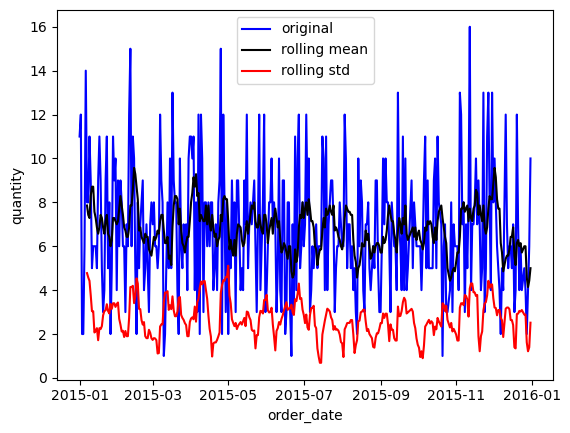

In [89]:
stationary_test(temp[['quantity']], 7, 'quantity', 'quantity')

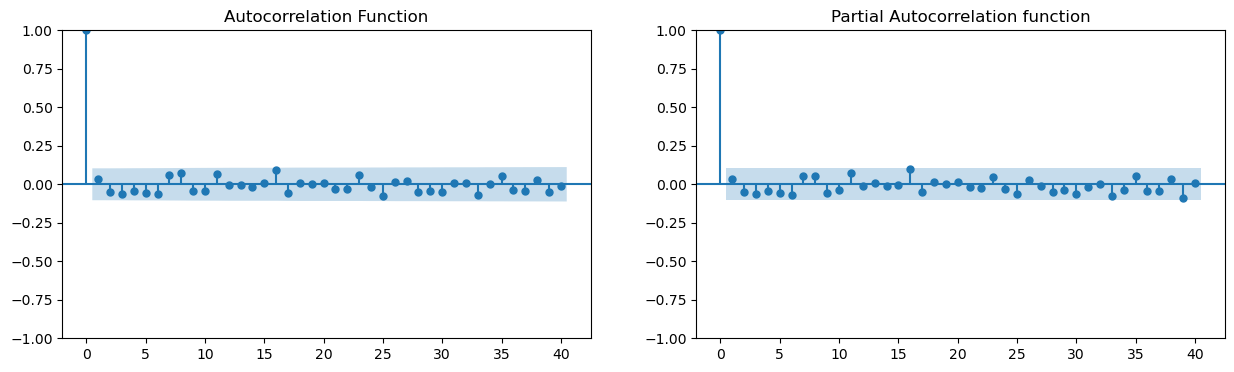

In [90]:
# pca and pacf plots 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plot_acf(temp['quantity'], lags=40, ax=plt.gca(), title='Autocorrelation Function')

plt.subplot(1,2,2)
plot_pacf(temp['quantity'], lags=40, ax=plt.gca(), title='Partial Autocorrelation function')
plt.show()

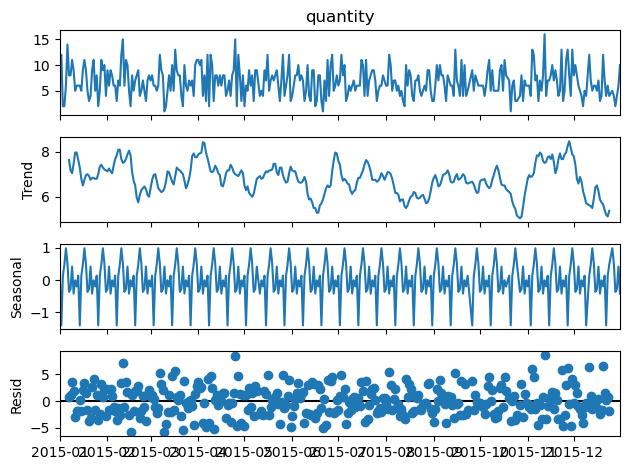

In [91]:
# seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(temp['quantity'], model='additive', period=12)
result.plot()
plt.show()

In [92]:
temp

,order_month,quantity
order_date,,
2015-01-01,1,11
2015-01-02,1,12
2015-01-03,1,2
2015-01-04,1,2
2015-01-05,1,6
...,...,...
2015-12-27,12,4
2015-12-28,12,2
2015-12-29,12,4


## Model Selection

## Arima Model

In [95]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(temp['quantity'], order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parame

                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  358
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -879.761
Date:                Thu, 24 Apr 2025   AIC                           1769.522
Time:                        23:07:15   BIC                           1788.911
Sample:                             0   HQIC                          1777.234
                                - 358                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7712      0.238      3.238      0.001       0.304       1.238
ar.L2         -0.0944      0.051     -1.855      0.064      -0.194       0.005
ma.L1         -1.7360      0.230     -7.540      0.0

In [96]:
temp.tail()

,order_month,quantity
order_date,,
2015-12-27,12,4
2015-12-28,12,2
2015-12-29,12,4
2015-12-30,12,6
2015-12-31,12,10


In [97]:
# forecast

steps = 7
forecast = model_fit.forecast(steps=7)
datetime = pd.date_range(start='1-1-2015', periods=7)

predicted = pd.DataFrame({
    'datetime':datetime,
    'forecasts':forecast
})
predicted

C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,datetime,forecasts
358,2015-01-01,7.315297
359,2015-01-02,6.844387
360,2015-01-03,6.734798
361,2015-01-04,6.694761
362,2015-01-05,6.674237
363,2015-01-06,6.662190
364,2015-01-07,6.654838


In [98]:
predicted.set_index('datetime', inplace=True)

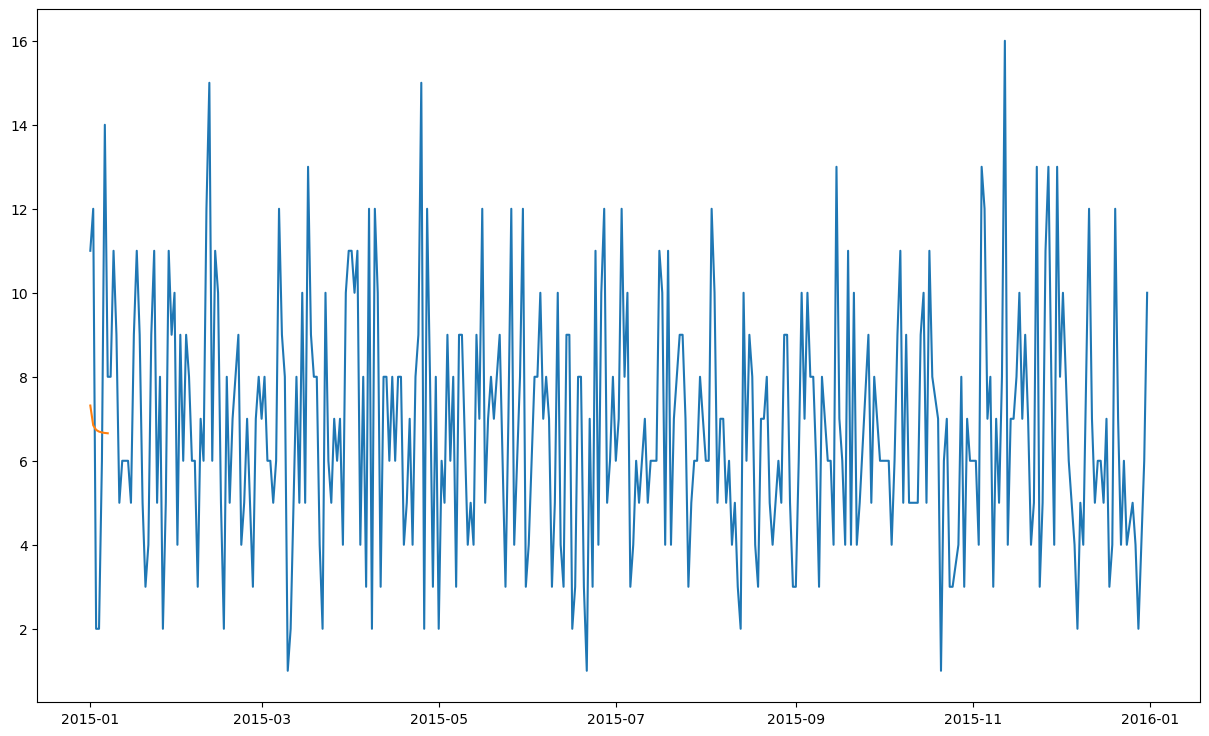

In [99]:
plt.figure(figsize=(15, 9))
plt.plot(temp['quantity'])
plt.plot(predicted['forecasts'])
plt.show()

## Sarimax Model

In [101]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(temp['quantity'], order=(2,1,2), seasonal_order=(2,5,7,7))

sarimax_fit = sarimax.fit(disp=False)

print(sarimax_fit.summary())

C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Ajay

                                               SARIMAX Results                                               
Dep. Variable:                                              quantity   No. Observations:                  358
Model:             SARIMAX(2, 1, 2)x(2, 5, [1, 2, 3, 4, 5, 6, 7], 7)   Log Likelihood               -1198.597
Date:                                               Thu, 24 Apr 2025   AIC                           2425.194
Time:                                                       23:08:33   BIC                           2478.038
Sample:                                                            0   HQIC                          2446.291
                                                               - 358                                         
Covariance Type:                                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [102]:
# forecast

steps = 7
forecast = sarimax_fit.forecast(steps=7)
datetime = pd.date_range(start='1-1-2015', periods=7)

predicted = pd.DataFrame({
    'datetime':datetime,
    'forecasts':forecast
})
predicted

C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,datetime,forecasts
358,2015-01-01,5.996972
359,2015-01-02,3.775667
360,2015-01-03,-2.835982
361,2015-01-04,4.123126
362,2015-01-05,-12.064214
363,2015-01-06,-3.658730
364,2015-01-07,9.650016


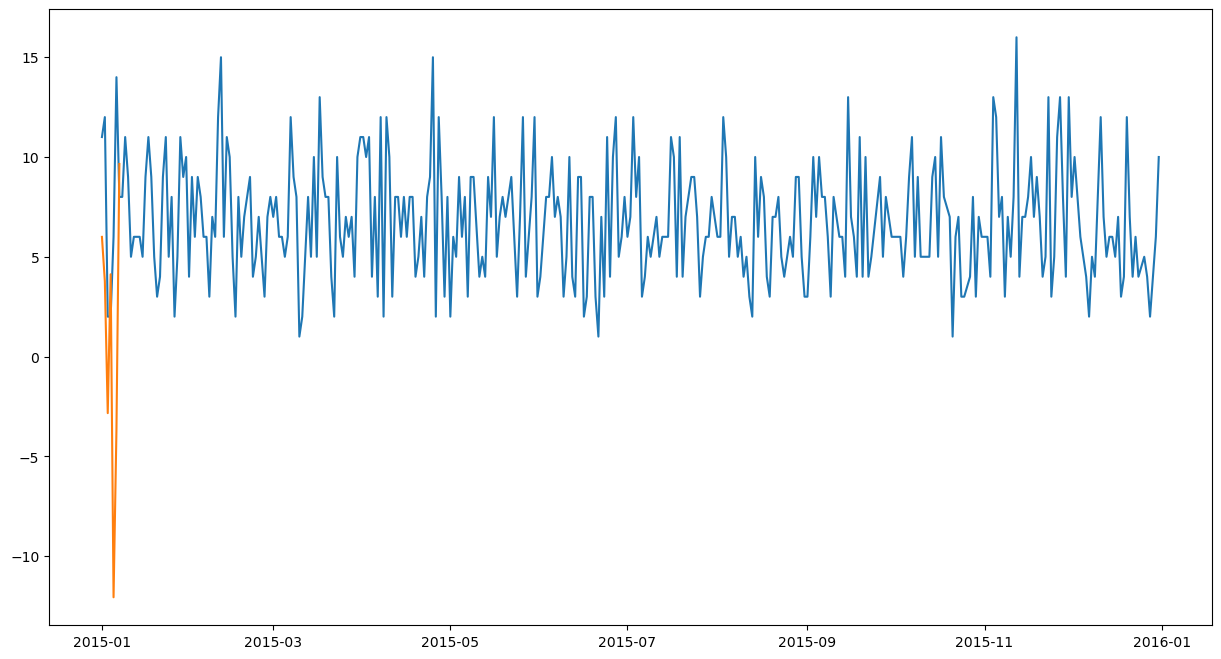

In [103]:
# vizualization 

predicted.set_index('datetime', inplace=True)

plt.figure(figsize=(15, 8))

plt.plot(temp['quantity'])
plt.plot(predicted['forecasts'])

plt.show()

## prophet model

In [105]:
temp.reset_index(inplace=True)

In [106]:
temp

,order_date,order_month,quantity
0,2015-01-01,1,11
1,2015-01-02,1,12
2,2015-01-03,1,2
3,2015-01-04,1,2
4,2015-01-05,1,6
...,...,...,...
353,2015-12-27,12,4
354,2015-12-28,12,2
355,2015-12-29,12,4
356,2015-12-30,12,6


In [107]:
temp['ds'] = pd.to_datetime(temp['order_date'])
temp['y'] = pd.to_datetime(temp['quantity'])

temp = temp[['ds', 'y']]


prophet = Prophet()

prophet.fit(temp)



23:08:34 - cmdstanpy - INFO - Chain [1] start processing
23:08:35 - cmdstanpy - INFO - Chain [1] done processing


In [108]:
# prediction 

future = prophet.make_future_dataframe(periods=7)

forecast = prophet.predict(future)

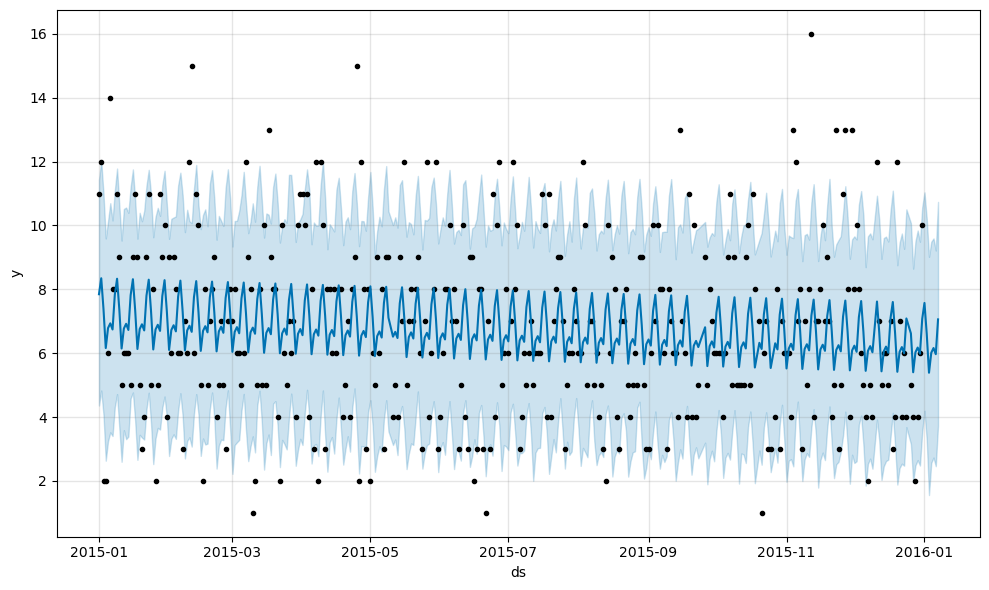

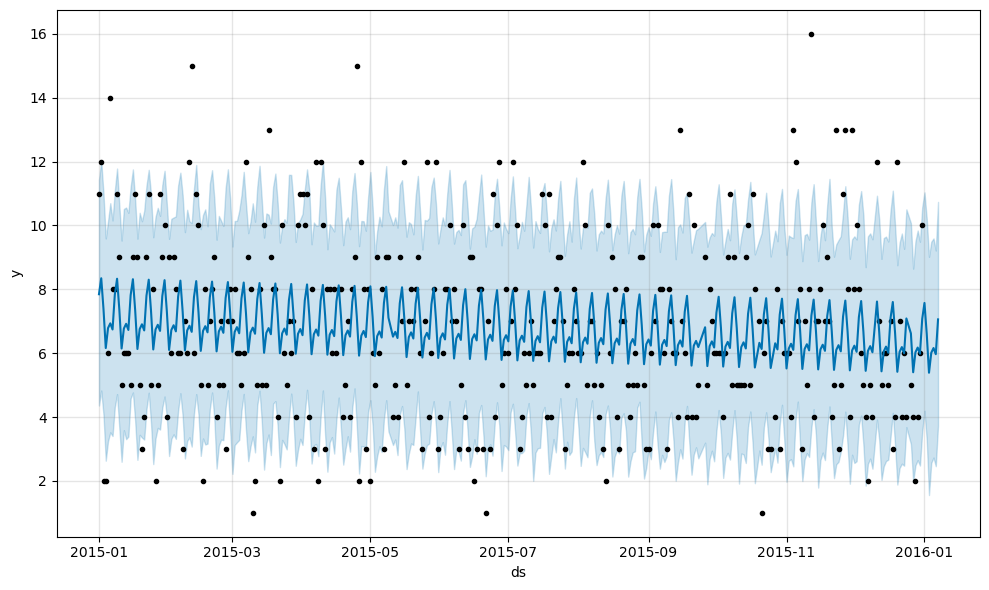

In [109]:
# vizualize

prophet.plot(forecast)

In [110]:
#cleaning 

sales_data['order_datetime'] = sales_data['order_datetime'].dt.date

sales_data = sales_data[['order_datetime', 'pizza_name', 'quantity']]

In [111]:
## converting to pivot table 

pivot_sales = sales_data.pivot_table(
    index='order_datetime',
    columns = 'pizza_name',
    values = 'quantity',
    aggfunc = 'sum',
    fill_value = 0,
)

pivot_sales

pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11,5,0,1,4,2,4,10,7,6,...,4,4,1,7,5,2,5,2,8,3
2015-01-02,12,9,3,7,15,3,2,13,5,6,...,6,5,3,9,9,5,3,4,8,1
2015-01-03,2,3,1,1,6,0,1,4,5,4,...,1,2,0,9,4,3,0,5,4,6
2015-01-04,2,3,0,2,3,3,2,8,7,6,...,4,8,6,10,4,4,6,1,3,5
2015-01-05,6,1,1,4,11,2,5,9,6,4,...,5,5,0,6,5,2,4,5,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,4,5,1,1,3,0,3,8,2,4,...,1,4,1,2,4,3,1,1,5,9
2015-12-28,2,3,1,1,5,2,3,9,2,4,...,5,4,5,3,2,2,2,3,6,3
2015-12-29,4,6,1,2,6,1,1,3,3,3,...,3,2,3,1,3,4,0,1,5,1


In [112]:
pizza_models = {}

for pizza_name in pivot_sales.columns:
    model = SARIMAX(pivot_sales[pizza_name], order=(1,1,0))
    model_fit = model.fit()
    pizza_models[pizza_name] = model_fit

C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

In [113]:
# forecasting

steps = 7
forecast_predictions = {}

for pizza_name, model in pizza_models.items():
    forecast_predictions[pizza_name] = model.predict(start= len(pivot_sales), end = len(pivot_sales)+steps-1)

C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Ajay\anaconda3\L

In [114]:
forecasts = pd.DataFrame(forecast_predictions)

In [115]:
forecasts

,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
358,8.163282,4.359358,0.888569,1.432509,7.0,2.418361,2.102540,7.119636,2.906248,7.042489,...,3.440105,2.285151,2.036685,5.912097,6.099148,3.448682,2.0,3.178298,3.0,7.835581
359,9.006665,5.256593,1.506208,2.251518,7.0,3.252222,3.002629,8.502385,4.002197,8.000451,...,4.251196,3.759232,2.500673,5.496137,7.301283,4.250878,2.0,4.007948,3.0,8.772523
360,8.619401,4.765913,1.162977,1.823589,7.0,2.812600,2.575658,7.838582,3.428536,7.531646,...,3.829457,2.958851,2.277190,5.685834,6.803109,3.836058,2.0,3.630104,3.0,8.366936
361,8.797225,5.034256,1.353716,2.047181,7.0,3.044374,2.778198,8.157248,3.728812,7.761069,...,4.048746,3.393434,2.384832,5.599323,7.009556,4.050564,2.0,3.802184,3.0,8.542508
362,8.715571,4.887505,1.247719,1.930355,7.0,2.922180,2.682120,8.004269,3.571636,7.648794,...,3.934724,3.157468,2.332985,5.638776,6.924003,3.939641,2.0,3.723814,3.0,8.466505
363,8.753065,4.967760,1.306623,1.991396,7.0,2.986602,2.727696,8.077708,3.653908,7.703739,...,3.994012,3.285590,2.357958,5.620784,6.959457,3.997000,2.0,3.759506,3.0,8.499406
364,8.735849,4.923870,1.273889,1.959502,7.0,2.952638,2.706076,8.042453,3.610844,7.676850,...,3.963184,3.216024,2.345930,5.628989,6.944764,3.967340,2.0,3.743251,3.0,8.485164


In [116]:
import pickle
import os

current_dir = os.getcwd()
try:
    os.mkdir('models')
except FileExistsError:
    print('folder already exist..')

folder already exist..


In [117]:
os.chdir('models')

In [118]:

for name, model in pizza_models.items():
    name = name.replace(' ', '_')
    with open(f'{name}.pkl', 'wb') as file:
        pickle.dump(model, file)

In [119]:
os.listdir()

['the_barbecue_chicken_pizza.pkl',
 'the_big_meat_pizza.pkl',
 'the_brie_carre_pizza.pkl',
 'the_calabrese_pizza.pkl',
 'the_california_chicken_pizza.pkl',
 'the_chicken_alfredo_pizza.pkl',
 'the_chicken_pesto_pizza.pkl',
 'the_classic_deluxe_pizza.pkl',
 'the_five_cheese_pizza.pkl',
 'the_four_cheese_pizza.pkl',
 'the_greek_pizza.pkl',
 'the_green_garden_pizza.pkl',
 'the_hawaiian_pizza.pkl',
 'the_italian_capocollo_pizza.pkl',
 'the_italian_supreme_pizza.pkl',
 'the_italian_vegetables_pizza.pkl',
 'the_mediterranean_pizza.pkl',
 'the_mexicana_pizza.pkl',
 'the_napolitana_pizza.pkl',
 'the_pepperoni,_mushroom,_and_peppers_pizza.pkl',
 'the_pepperoni_pizza.pkl',
 'the_pepper_salami_pizza.pkl',
 'the_prosciutto_and_arugula_pizza.pkl',
 'the_sicilian_pizza.pkl',
 'the_soppressata_pizza.pkl',
 'the_southwest_chicken_pizza.pkl',
 'the_spicy_italian_pizza.pkl',
 'the_spinach_and_feta_pizza.pkl',
 'the_spinach_pesto_pizza.pkl',
 'the_spinach_supreme_pizza.pkl',
 'the_thai_chicken_pizza.pkl',

In [120]:
os.chdir(current_dir)